## Melanoma detection

In [1]:
# Imported libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hashlib

import imghdr
from PIL import Image

from image_data_validator import ImageDataValidator

/tmp/ipykernel_58634/3026258462.py:9: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [2]:
base_dir = "./DATA/"

directories = [
    f"{base_dir}test/Benign",
    f"{base_dir}test/Malignant",
    f"{base_dir}train/Benign",
    f"{base_dir}train/Malignant"
]

## Verificando a Integridade dos Arquivos

In [3]:
# Methods: __check_directory_file; check_extension

validator = ImageDataValidator(images_dir=directories, width=224, height=224, extensions=["jpg", "jpeg"])
display(validator.sizes)

{'./DATA/test/Benign': 1000,
 './DATA/test/Malignant': 1000,
 './DATA/train/Benign': 6289,
 './DATA/train/Malignant': 5590}

Podemos concluir que o total de arquivos contidos dentro do diretório é igual ao total de imagens, como tambem podemos afirmar que todas elas estão em "jpeg", assim como tambem não há imagens ausentes.

## Verificando a Consistência dos Metadados

Observando com o ExifTags do Pillow, notamos que não há metadados nativos. Portanto, foi necessário incluir metadados adicionais.

In [4]:
# Methods: check_metadata; create_metadata

df = pd.DataFrame(validator.dimensions)
df

,image_name,width,height,class
0,6646.jpg,224,224,Benign
1,6836.jpg,224,224,Benign
2,6654.jpg,224,224,Benign
3,6713.jpg,224,224,Benign
4,7041.jpg,224,224,Benign
...,...,...,...,...
13874,2785.jpg,224,224,Malignant
13875,5189.jpg,224,224,Malignant
13876,3784.jpg,224,224,Malignant
13877,1021.jpg,224,224,Malignant


### Verificando se estatísticamente há alguma imagem fora da dimensão

In [5]:
display(df.describe())

,width,height
count,13879.0,13879.0
mean,224.0,224.0
std,0.0,0.0
min,224.0,224.0
25%,224.0,224.0
50%,224.0,224.0
75%,224.0,224.0
max,224.0,224.0


Podemos concluir que todas as imagens estão na mesma dimensão

## Qualidade das imagens
- Verificando imagens corrompidas que não podem ser abertas ou
processadas.

In [6]:
# Methods: check_quality

validator.images

{'./DATA/test/Benign/6646.jpg': '6646.jpg',
 './DATA/test/Benign/6836.jpg': '6836.jpg',
 './DATA/test/Benign/6654.jpg': '6654.jpg',
 './DATA/test/Benign/6713.jpg': '6713.jpg',
 './DATA/test/Benign/7041.jpg': '7041.jpg',
 './DATA/test/Benign/6788.jpg': '6788.jpg',
 './DATA/test/Benign/6987.jpg': '6987.jpg',
 './DATA/test/Benign/6827.jpg': '6827.jpg',
 './DATA/test/Benign/6948.jpg': '6948.jpg',
 './DATA/test/Benign/6904.jpg': '6904.jpg',
 './DATA/test/Benign/6737.jpg': '6737.jpg',
 './DATA/test/Benign/6350.jpg': '6350.jpg',
 './DATA/test/Benign/6437.jpg': '6437.jpg',
 './DATA/test/Benign/7100.jpg': '7100.jpg',
 './DATA/test/Benign/6723.jpg': '6723.jpg',
 './DATA/test/Benign/6859.jpg': '6859.jpg',
 './DATA/test/Benign/6401.jpg': '6401.jpg',
 './DATA/test/Benign/7289.jpg': '7289.jpg',
 './DATA/test/Benign/6597.jpg': '6597.jpg',
 './DATA/test/Benign/7113.jpg': '7113.jpg',
 './DATA/test/Benign/6897.jpg': '6897.jpg',
 './DATA/test/Benign/6362.jpg': '6362.jpg',
 './DATA/test/Benign/6954.jpg': 

Pudemos verificar que todas as imagens podem ser abertas sem erros e portanto não há imagens corrompidas e que não podem ser processadas.

## Distribuição das Classes
- Verificando a distribuição das classes para identificar possíveis
desequilíbrios que possam afetar a modelagem

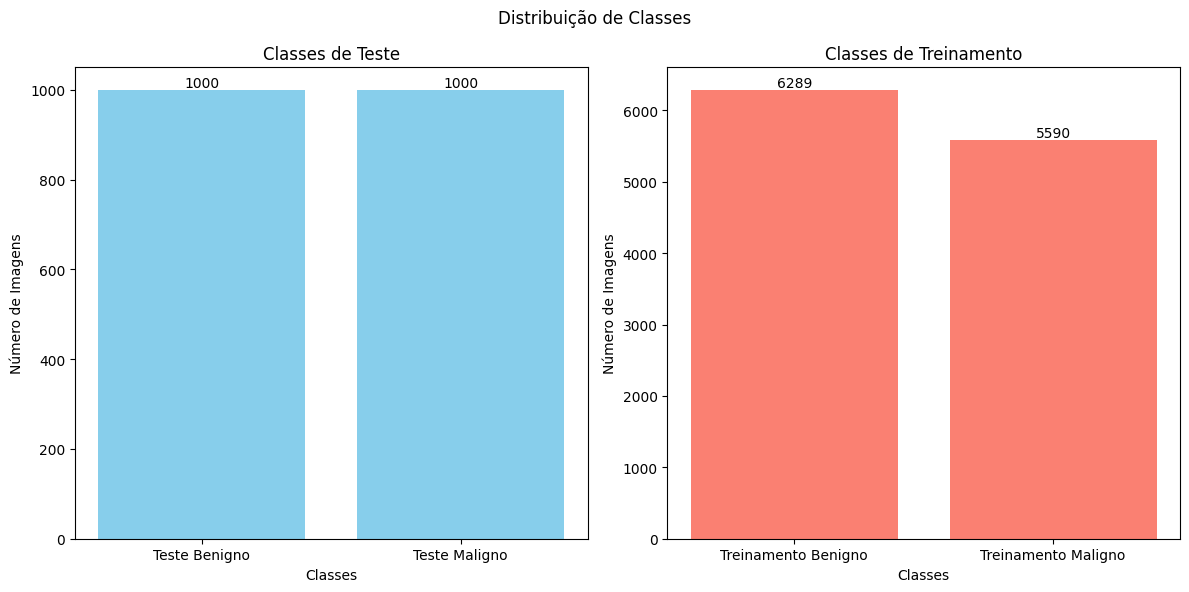

In [7]:
def plot_class_distribution(distribution, title):
    classes = list(distribution.keys())
    counts = list(distribution.values())

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].bar(classes[:2], counts[:2], color='skyblue')
    axs[0].set_title('Classes de Teste')
    axs[0].set_xlabel('Classes')
    axs[0].set_ylabel('Número de Imagens')
    axs[0].set_xticks(range(len(classes[:2])))
    axs[0].set_xticklabels(['Teste Benigno', 'Teste Maligno'])

    axs[1].bar(classes[2:], counts[2:], color='salmon')
    axs[1].set_title('Classes de Treinamento')
    axs[1].set_xlabel('Classes')
    axs[1].set_ylabel('Número de Imagens')
    axs[1].set_xticks(range(len(classes[2:])))
    axs[1].set_xticklabels(['Treinamento Benigno', 'Treinamento Maligno'])

    for ax in axs:
        for i, count in enumerate(counts[:2] if ax == axs[0] else counts[2:]):
            ax.text(i, count, str(count), ha='center', va='bottom')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_class_distribution(validator.sizes, 'Distribuição de Classes')

#### Análise do Desequilíbrio

**Distribuição Observada:**
- **Treino:**
  - `Benign`: 6289 imagens
  - `Malignant`: 5590 imagens
- **Teste:**
  - `Benign`: 1000 imagens
  - `Malignant`: 1000 imagens

**Desequilíbrio no Treino:**
- A diferença entre o número de imagens das classes `Benign` e `Malignant` no conjunto de treino é de 699 imagens.
- Percentualmente, isso representa aproximadamente 5,6% de diferença entre as duas classes.

### Impacto Potencial

1. **Modelagem e Treinamento:**
   - **Classificação Desbalanceada**: Um pequeno desequilíbrio pode não ser um problema grave, mas pode afetar o desempenho do modelo. Modelos de aprendizado de máquina tendem a ser mais sensíveis a desequilíbrios de classe quando a diferença é significativa.
   - **Bias do Modelo**: O modelo pode desenvolver um viés em direção à classe com mais imagens, o que pode resultar em uma menor performance na classe minoritária.

2. **Métricas de Avaliação:**
   - **Acurácia**: Pode ser enganosa em conjuntos de dados desbalanceados. Mesmo que o modelo tenha uma alta acurácia, isso não garante uma boa performance em todas as classes.
   - **Outras Métricas**: Métricas como precisão, recall e F1-score podem fornecer uma visão mais clara do desempenho do modelo, especialmente para a classe minoritária.

### Estratégias para Lidar com Desequilíbrios

Se você decidir que o desequilíbrio pode afetar o treinamento do seu modelo, aqui estão algumas estratégias que você pode considerar:

1. **Reamostragem:**
   - **Oversampling**: Aumentar o número de exemplos na classe minoritária (por exemplo, duplicando imagens ou gerando novas imagens sintéticas).
   - **Undersampling**: Reduzir o número de exemplos na classe majoritária.

2. **Ajuste de Pesos:**
   - Ajustar os pesos das classes no modelo para penalizar mais erros na classe minoritária.

3. **Aumento de Dados:**
   - Aplicar técnicas de aumento de dados (data augmentation) para a classe minoritária para criar variações das imagens existentes.

4. **Validação Cruzada:**
   - Utilizar técnicas de validação cruzada para garantir que o modelo generalize bem para diferentes divisões dos dados.

5. **Métricas de Avaliação:**
   - Focar em métricas mais informativas como F1-score, precision-recall curve e ROC curve, que podem dar uma melhor indicação do desempenho do modelo nas diferentes classes.

### Conclusão

Embora o desequilíbrio no conjunto de treino não seja grande, é uma boa prática monitorar como isso pode impactar o desempenho do seu modelo. Implementar algumas das estratégias mencionadas pode ajudar a mitigar o impacto e garantir que o modelo esteja bem equilibrado em relação às classes.

## Verificando Duplicatas

#### Hash MD5
- o que é?

O hash MD5 (Message Digest Algorithm 5) é uma função de hash criptográfico que gera um valor de hash de 128 bits (ou 16 bytes), normalmente representado como uma sequência hexadecimal de 32 dígitos. O MD5 é utilizado para verificar a integridade dos dados, criar assinaturas digitais e identificar de forma única o conteúdo de um arquivo ou mensagem.

Características do MD5
Determinístico: Para um dado específico de entrada, o hash MD5 sempre gera o mesmo valor de hash.
Rapidez: O cálculo do hash MD5 é muito rápido, tornando-o eficiente para processamento de grandes quantidades de dados.
Comprimento Fixado: Independentemente do tamanho da entrada, o valor de hash MD5 sempre terá 128 bits (32 caracteres hexadecimais).
Unicidade: Idealmente, duas entradas diferentes não devem gerar o mesmo valor de hash (uma propriedade chamada de "pre-image resistance"). No entanto, devido a coligações descobertas, isso não é garantido em todos os casos.
Usos Comuns
Verificação de Integridade: O MD5 é frequentemente utilizado para verificar se os arquivos foram corrompidos ou alterados. Por exemplo, ao baixar um arquivo, você pode comparar o hash MD5 do arquivo baixado com o hash fornecido pelo site para garantir que o arquivo está intacto.
Identificação de Arquivos: Ao calcular o hash MD5 de um arquivo, você pode identificar arquivos duplicados com base na comparação dos valores de hash.

In [8]:
# Methods: find_duplicate_images

if not validator.duplicates:
    display("Não há nenhuma duplicata")
else:
    display(validator.duplicates)

'Não há nenhuma duplicata'

In [9]:
validator.images_hashes

{'e0b18554ae0eceada17c4892d05ee858': '6646.jpg',
 '5b19656d72b768028135f88c196e354d': '6836.jpg',
 '85c82b4af11d44955b81900dd0b0e112': '6654.jpg',
 'a599b7e32352b371620768b7cab94543': '6713.jpg',
 'c3d1b2b26243a8a54b9fecbe27f32d45': '7041.jpg',
 'ce17ce8247b8c544647a897edf3a1304': '6788.jpg',
 'e02edece54b3619fb45c8c2d3644c064': '6987.jpg',
 '85a37171df21cbf35ad2ddd17304e0ff': '6827.jpg',
 'b42fba31737bd7e6db2d1fafffc16dfa': '6948.jpg',
 'c3ca00705c49ddbcfd7c157c80945905': '6904.jpg',
 'ccdf493f9cd7468256a9e16e6fa599c8': '6737.jpg',
 'e8f93254805fba8679ae90b0731f55d2': '6350.jpg',
 '240f1390d810b8bbfb38a55ea8172e13': '6437.jpg',
 '4f6beb42a4e96d13445bcc2384bef4b9': '7100.jpg',
 'a16273d32b02835959c42f9263a926a2': '6723.jpg',
 'eaf42f49bd225128ac1f19d2ca07a56a': '6859.jpg',
 'a3cc062466ce1d5a392af486c36f8545': '6401.jpg',
 '271270caefd152023d6b06c45bc21b3f': '7289.jpg',
 'a36c2cc5f65e087da0aadad89504144d': '6597.jpg',
 'e975d77c47dda9d874f9d6a18cb16a32': '7113.jpg',
 '36aba242f6904c949f

Pode-se concluir com o código acima que não há imagens duplicadas.

## Inconsistências nas imagens
Testando inconsistências nas imagens de teste: largura incorreta e extensão inadequada.

In [10]:
validator2 = ImageDataValidator(images_dir=[directories[0]], width=225, height=224, extensions=["png"])

In [11]:
pd.DataFrame(validator2.inconsistencies)

,file_path,error,issue
0,./DATA/test/Benign/6646.jpg,Invalid extension,Extension check failed
1,./DATA/test/Benign/6646.jpg,No metadata,Metadata check failed
2,./DATA/test/Benign/6646.jpg,Dimension mismatch,Dimension check failed
3,./DATA/test/Benign/6836.jpg,Invalid extension,Extension check failed
4,./DATA/test/Benign/6836.jpg,No metadata,Metadata check failed
...,...,...,...
2995,./DATA/test/Benign/6418.jpg,No metadata,Metadata check failed
2996,./DATA/test/Benign/6418.jpg,Dimension mismatch,Dimension check failed
2997,./DATA/test/Benign/7264.jpg,Invalid extension,Extension check failed
2998,./DATA/test/Benign/7264.jpg,No metadata,Metadata check failed


## Informações Complementares

- [x] Elaborar uma apresentação para mostrar os resultados.
- [x] Apresentar o dataset de forma detalhada.
- [x] Verificar quais itens em Informações esperadas podem ser aplicados no dataset.
